# Working with data

Let's begin by grabbing some data to review a few ways to work with data in SunPy.

In [149]:
import numpy as np
import matplotlib.pyplot as plt

import sunpy
import sunpy.map
import astropy.units as u
from astropy.time import TimeDelta
from sunpy.net import hek, Fido, attrs as a
from sunpy.time import parse_time
from sunpy.coordinates import frames
from sunpy.physics.differential_rotation import solar_rotate_coordinate

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from reproject import reproject_interp

In [150]:
res = Fido.search(a.Time('2019-01-01T00:00:00', '2019-01-01T01:00:00'),
                  a.Instrument('aia'), 
                  a.Wavelength(193*u.angstrom), 
                  a.vso.Sample(20*u.minute))
res

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2019-01-01 00:40:04,2019-01-01 00:40:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-01-01 00:00:04,2019-01-01 00:00:05,SDO,AIA,FULLDISK,193.0 .. 193.0
2019-01-01 00:20:04,2019-01-01 00:20:05,SDO,AIA,FULLDISK,193.0 .. 193.0


In [151]:
ores = Fido.fetch(res[0,0], path='./data');

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.19file/s]


In [152]:
m0 = sunpy.map.Map(ores.data[0])

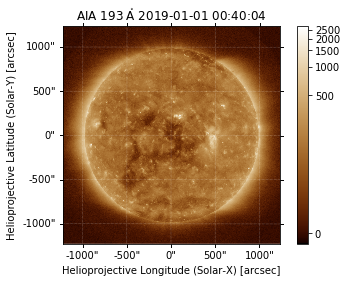

In [153]:
m0.peek()

In [154]:
hpc_coords = sunpy.map.maputils.all_coordinates_from_map(m0)
rarr = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / m0.rsun_obs
m0.data[np.where(rarr>=1)] = 0 # Note the issue of using int16 here and NaNs

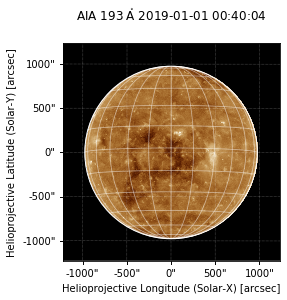

In [155]:
m0.plot()
m0.draw_limb()
m0.draw_grid()

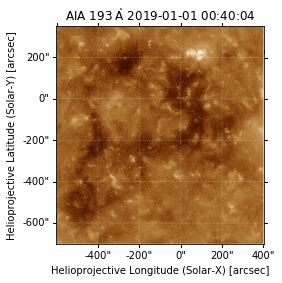

In [156]:
lm0 = m0.resample([256,256]*u.pixel)
sm0 = m0.submap(SkyCoord(-600*u.arcsec,-700*u.arcsec,frame=m0.coordinate_frame), 
                SkyCoord(400*u.arcsec,350*u.arcsec,frame=m0.coordinate_frame))
sm0.plot()

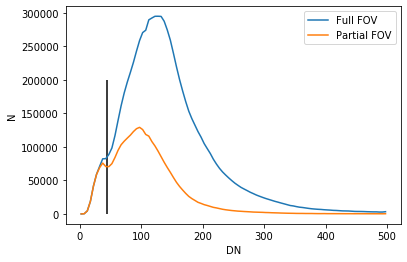

In [157]:
hist, bins = np.histogram(m0.data[m0.data>0], bins=100, range=[0,500])
shist, bins = np.histogram(sm0.data[sm0.data>0], bins=100, range=[0,500])
x = (bins[:-1] + bins[1:]) / 2
plt.plot(x, hist, label='Full FOV')
plt.plot(x, shist, label='Partial FOV')
plt.vlines(45,0,2e5,)
plt.xlabel('DN')
plt.ylabel('N')
plt.legend()

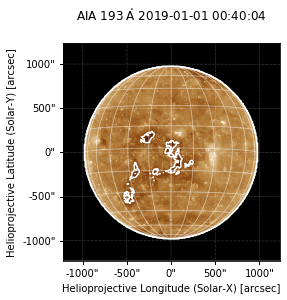

In [158]:
lm0.plot()
lm0.draw_limb()
lm0.draw_grid()
lm0.draw_contours([1.666]*u.percent, colors='w')

In [159]:
oshape = [720,1440]
header = sunpy.map.make_fitswcs_header(np.empty(oshape),
                   SkyCoord(0, 0, unit=u.deg,
                            frame="heliographic_carrington",
                            obstime=m0.date),
                   scale=[180 / oshape[0],
                          360 / oshape[1]] * u.deg / u.pix,
                   projection_code="CAR");

out_wcs = WCS(header);

array, footprint = reproject_interp(
        (m0.data, m0.wcs), out_wcs, shape_out=oshape);
om0 = sunpy.map.Map((array, header));

/usr/local/lib/python3.7/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):
/usr/local/lib/python3.7/site-packages/reproject/array_utils.py:85: RuntimeWarning: invalid value encountered in less
  reset |= (coords[i] < -0.5)
/usr/local/lib/python3.7/site-packages/reproject/array_utils.py:86: RuntimeWarning: invalid value encountered in greater
  reset |= (coords[i] > image.shape[i] - 0.5)


/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1200: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/usr/local/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


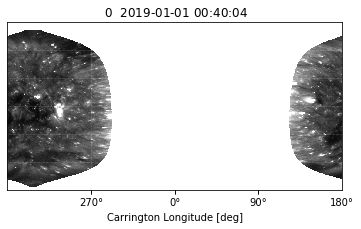

In [160]:
om0.plot(vmin=0, vmax=500)
om0.draw_contours([25,50]*u.percent)

In [161]:
hek_client = hek.HEKClient()
start_time = m0.date - TimeDelta(1*u.hour)
end_time = m0.date + TimeDelta(1*u.hour)
responses = hek_client.search(hek.attrs.Time(start_time, end_time),
                              hek.attrs.CH, hek.attrs.FRM.Name == 'SPoCA')

chbounds = []

for i in np.arange(len(responses)):
    ch = responses[i]
    p1 = ch["hpc_boundcc"][9:-2]
    p2 = p1.split(',')
    p3 = [v.split(" ") for v in p2]
    ch_date = parse_time(ch['event_starttime'])
    
    ch_boundary = SkyCoord(
    [(float(v[0]), float(v[1])) * u.arcsec for v in p3],
    obstime=ch_date,
    frame=frames.Helioprojective);
    chbounds.append(solar_rotate_coordinate(ch_boundary, time=m0.date));

/usr/local/lib/python3.7/site-packages/sunpy/physics/differential_rotation.py:153: UserWarning: Using 'time' assumes an Earth-based observer.
  warnings.warn("Using 'time' assumes an Earth-based observer.")


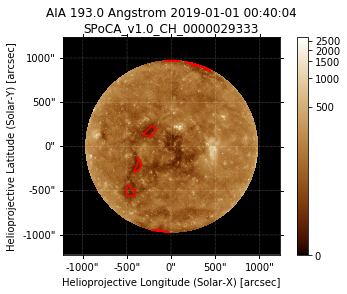

In [162]:
fig = plt.figure()
ax = plt.subplot(projection=m0)
m0.plot(axes=ax)
for i in np.arange(len(chbounds)):
    ax.plot_coord(chbounds[i], color='r')
ax.set_title('{:s}\n{:s}'.format(m0.name, ch['frm_specificid']))
plt.colorbar()
plt.show()

In [ ]:
# Now let's overlay a magnetogram to gauge the unipolarity of each suspected region